## __Objective:__ Create a multiclass image classifier

## __Purpose:__ Can be used to classify  species of animal

### Use transfer learning and vgg16 model

### importing necessary libraries

In [1]:
import pandas as pd
import numpy as np 
import itertools
from tensorflow import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.models import Sequential 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense  
from tensorflow.keras import applications  
from tensorflow.keras.utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math  
import datetime
import time


Loading up our image datasets

In [2]:
#Default dimensions we found online
img_width, img_height = 224, 224  
   
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5' 

# loading up our datasets
train_data_dir = 'data/train'  
validation_data_dir = 'data/valid'  
test_data_dir = 'data/test'
   
# number of epochs to train top model  
epochs = 7 #this has been changed after multiple model run  
# batch size used by flow_from_directory and predict_generator  
batch_size = 50  

In [3]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights=None) 

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)  #needed to create the bottleneck .npy files

# Creation of weights/features with VGG16

In [5]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 2492 images belonging to 2 classes.


/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/opt/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Time:  0:05:40.891660


In [6]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 694 images belonging to 2 classes.
Time:  0:01:34.219910


In [7]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 179 images belonging to 2 classes.
Time:  0:00:24.876100


# Loading training, validation and testing data

In [8]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=True)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 2492 images belonging to 2 classes.


In [9]:
number_list=train_labels[:,0]

In [10]:
(unique, counts) = np.unique(number_list, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[0.000e+00 3.480e+02]
 [1.000e+00 2.144e+03]]


In [11]:
#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=True)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 694 images belonging to 2 classes.


In [12]:
#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=True)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 179 images belonging to 2 classes.


In [13]:
class_weight = {0: 4.,
                1: 1.,}

# Training of model

In [14]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 

model.add(Dense(num_classes, activation='sigmoid'))  

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=10,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels),class_weight=class_weight)  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/10
50/50 [==============================] - 2s 28ms/step - loss: 2.1675 - acc: 0.8188 - val_loss: 0.5465 - val_acc: 0.7896
Epoch 2/10
50/50 [==============================] - 1s 16ms/step - loss: 1.3654 - acc: 0.8663 - val_loss: 0.5203 - val_acc: 0.7896
Epoch 3/10
50/50 [==============================] - 1s 18ms/step - loss: 0.8581 - acc: 0.8621 - val_loss: 0.6056 - val_acc: 0.7896
Epoch 4/10
50/50 [==============================] - 1s 21ms/step - loss: 0.6451 - acc: 0.8667 - val_loss: 0.6964 - val_acc: 0.7896
Epoch 5/10
50/50 [==============================] - 1s 15ms/step - loss: 0.6000 - acc: 0.8689 - val_loss: 0.7239 - val_acc: 0.7896
Epoch 6/10
50/50 [==============================] - 1s 15ms/step - loss: 0.6391 - acc: 0.8548 - val_loss: 0.7366 - val_acc: 0.7896
Epoch 7/10
50/50 [==============================] - 1s 17ms/step - loss: 0.6098 - acc: 0.8645 - val_loss: 0.7313 - val_acc: 0.7896
Epoch 8/10
50/50 [==============================] - 1s 20ms/step - loss: 0.6108 - a

In [ ]:
#Model summary
model.summary()

## Model Evaluation on Testing Set

In [15]:
model.evaluate(test_data, test_labels)

6/6 [==============================] - 0s 5ms/step - loss: 0.6128 - acc: 0.8324


[0.6128278374671936, 0.832402229309082]

## Evaluation Matrix

In [16]:
print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)

test data [[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    2.31391788e-01 0.00000000e+00]
   [1.21679522e-01 0.00000000e+00 1.97928452e+00 ... 0.00000000e+00
    6.63630843e-01 0.00000000e+00]
   ...
   [0.00000000e+00 0.00000000e+00 1.79248476e+00 ... 0.00000000e+00
    1.39830983e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.10616398e+00 0.00000000e+00]
   [1.28015727e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    6.76013350e-01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 1.58324897e-01 ... 0.00000000e+00
    3.62342596e-01 0.00000000e+00]
   [0.00000000e+00 4.56636071e-01 1.62325525e+00 ... 3.34556997e-02
    9.68558192e-02 0.00000000e+00]
   [1.02060580e+00 0.00000000e+00 2.18553019e+00 ... 0.00000000e+00
    7.10123539e-01 0.00000000e+00]
   ...
   [8.36496711e-01 0.00000000e+00 1.50213623e+0

In [17]:
animals = ['non-vegan', 'vegan']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=animals )
print(classification_metrics)

              precision    recall  f1-score   support

   non-vegan       0.85      1.00      0.92       150
       vegan       1.00      0.10      0.18        30

   micro avg       0.85      0.85      0.85       180
   macro avg       0.92      0.55      0.55       180
weighted avg       0.87      0.85      0.79       180
 samples avg       0.85      0.85      0.85       180



In [18]:
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [19]:
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

In [20]:
#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Confusion matrix, without normalization


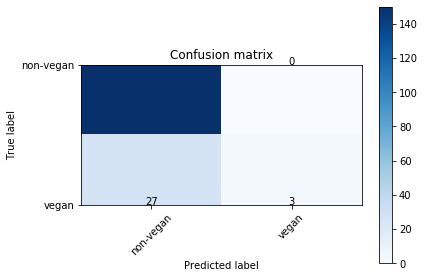

In [21]:
plot_confusion_matrix(confusion_matrix, ['non-vegan', 'vegan'])

Normalized confusion matrix


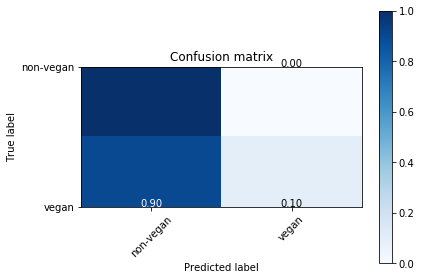

In [22]:
#Those numbers are all over the place. Now turning normalize= True
plot_confusion_matrix(confusion_matrix, 
                      ['non-vegan', 'vegan'],
                     normalize=True)

## Xception##

In [11]:
xception = applications.Xception(include_top=False, weights='imagenet') 

In [12]:
#Create a bottleneck file
top_model_weights_path_xception = 'bottleneck_fc_model_xception.h5' 

In [13]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=True)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = xception.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train_xception.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 2686 images belonging to 2 classes.
Time:  0:03:11.232913


In [14]:
#__this can take half an hour to run so only run it once. once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__

start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=True)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = xception.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation_xception.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 694 images belonging to 2 classes.
Time:  0:00:42.587792


In [15]:
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=True)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train_xception.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=True)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation_xception.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

Found 2686 images belonging to 2 classes.
Found 694 images belonging to 2 classes.


In [16]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.5))  
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(Dropout(0.3)) 

model.add(Dense(num_classes, activation='sigmoid'))  

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])  

history = model.fit(train_data, train_labels,  
      epochs=20,
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path_xception)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/20
54/54 [==============================] - 5s 78ms/step - loss: 0.9244 - acc: 0.8110 - val_loss: 0.5937 - val_acc: 0.7896
Epoch 2/20
54/54 [==============================] - 4s 69ms/step - loss: 0.5351 - acc: 0.8341 - val_loss: 0.6301 - val_acc: 0.7867
Epoch 3/20
54/54 [==============================] - 4s 68ms/step - loss: 0.5432 - acc: 0.8249 - val_loss: 0.7740 - val_acc: 0.7896
Epoch 4/20
54/54 [==============================] - 4s 71ms/step - loss: 0.4885 - acc: 0.8534 - val_loss: 0.6645 - val_acc: 0.7781
Epoch 5/20
54/54 [==============================] - 4s 70ms/step - loss: 0.4605 - acc: 0.8542 - val_loss: 0.8291 - val_acc: 0.7882
Epoch 6/20
54/54 [==============================] - 4s 68ms/step - loss: 0.4882 - acc: 0.8422 - val_loss: 0.6808 - val_acc: 0.7608
Epoch 7/20
54/54 [==============================] - 4s 68ms/step - loss: 0.4361 - acc: 0.8574 - val_loss: 0.7718 - val_acc: 0.6513
Epoch 8/20
54/54 [==============================] - 4s 68ms/step - loss: 0.4821 - a